In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Activation

from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import average_precision_score

import numpy as np
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import cv2
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import glob, os, shutil

import datetime, time

from IPython.display import display
from IPython.display import clear_output

In [2]:
plt.rcParams["axes.grid"] = False

In [3]:
class Own_Model:
    __model = None
    __classes = []
    
    __model_dims = None
    __history = None
    
    def __init__(self, classes = ['Not Whale', 'Whale'], model_dims = (224, 224, 3), learning_rate = 0.0000001):
        """
        # Builds the model then saves it for later use (Training/Testing/Detection).
        
        # Inputs:
            # model_dims -> Shape of the image inputs (32x32 images are resized to this size).
            # learning_rate -> Learning rate used in the 'model.compile()' function.
            
        # Outputs:
            1. Shows a summary of the model using 'model.summary()' function from Tensorflow.
        
        # Returns:
            # None.
        """
        self.__classes = classes
        self.__model_dims = model_dims
        
        base_model = tf.keras.applications.ResNet152V2(input_shape = (224, 224, 3), include_top=False, weights='imagenet')
        base_model.trainable = True

        self.__model = tf.keras.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            Activation('relu'),
            layers.Dense(len(classes), activation = 'softmax'),
        ])

        self.__model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                      optimizer = tf.keras.optimizers.RMSprop(lr=learning_rate),
                      metrics=['accuracy'])
        
#         self.__model.summary()
        
    def show_train_results(self):
        """
        # Builds the model then saves it for later use (Training/Testing/Detection).
        
        # Inputs:
            # model_dims -> Shape of the image inputs for MobileNetV2 (32x32 images are resized to this size).
            # learning_rate -> Learning rate used in the 'model.compile()' function.
            
        # Outputs:
            1. Shows a summary of the model using 'model.summary()' function from Tensorflow.
        
        # Returns:
            # None.
        """
        acc = self.__history.history['accuracy']
        val_acc = self.__history.history['val_accuracy']

        loss = self.__history.history['loss']
        val_loss = self.__history.history['val_loss']

        plt.figure(figsize=(30, 15))

        plt.subplot(2, 1, 1)
        plt.plot(acc, label='Training Accuracy')
        plt.plot(val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.ylabel('Accuracy')
        plt.ylim([0, 1.2])
        plt.title('Training and Validation Accuracy')

        plt.subplot(2, 1, 2)
        plt.plot(loss, label='Training Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.ylabel('Cross Entropy')
        plt.ylim([0, 1.5])
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')

        plt.show()
        
        
    def load_model(self, file_path):
        """
        # Loads previously trained model weights from a file into the model.
        
        # Inputs:
            # file_path -> Path to the model (.h5) file.
            
        # Outputs:
            # None.
        
        # Returns:
            # None.
        """
        self.__model.load_weights(file_path)
        
        
    def fit(self, train_path, val_path, num_epochs = 20, model_save_name = "detection_model"):
        """
        # Trains the model using the training and validation data. Also saves the model as a .h5 file to the 'model_save_path' specified.
        # Notes: 
        #    1. Data is expected to be NxN square images (32x32 is used by me).
        #    2. This function uses ImageDataGenerator from Tensorflow (https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) to find the data and train the model.
        #    3. Automatically detects the classes of the images from the folder names. In this case, the classes are 'Not Whale' and 'Whale' (Because 'ImageDataGenerator' reads them in alphebetical order).
        
        # Inputs:
            # train_path -> Path to the training data.
            # val_path -> Path to the validation data.
            # model_save_path -> Path to where the model will be saved.
            
        # Outputs:
            # None.
        
        # Returns:
            # None.
        """
        
        datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=True
        )
        
        print("Training data:")
        train_generator = datagen.flow_from_directory(
            directory = train_path,
            batch_size = 4,
            target_size = (self.__model_dims[0], self.__model_dims[1]),
            class_mode='categorical'
        )

        print("Validation data:")
        val_generator = datagen.flow_from_directory(
            directory = val_path,
            batch_size = 4,
            target_size= (self.__model_dims[0], self.__model_dims[1]),
            class_mode='categorical',
            shuffle = False
        )
        
        print("\n")
        
#         model_checkpoint = tf.keras.callbacks.ModelCheckpoint('detection_model_checkpoints/'+model_save_name+'{epoch:02d}.h5', save_freq = 5, save_weights_only=True)
        start = time.time()
    
        self.__history = self.__model.fit(
            train_generator,
            epochs = num_epochs,
#             callbacks=[model_checkpoint],
            validation_data=val_generator,
            verbose = 1
        )
        
        self.__model.save_weights(filepath = model_save_name+'.h5')
        
        end = time.time()
        hours, rem = divmod(end-start, 3600)
        minutes, seconds = divmod(rem, 60)
        print("Time Taken: {:0>2}:{:0>2}:{:05.3f}".format(int(hours),int(minutes),seconds))
        
        
    def evaluate(self, folder_path):
        """
        # Evaluates the trained model against the folder of images provided.
        # Notes: 
        #    1. Data is expected to be NxN square images (32x32 is used by me).
        
        # Inputs:
            # folder_path -> Path to the training data.
            
        # Outputs:
            1. Confusion Matrix for the Classification.
            2. A Classification Report using SKlearns 'classification_report()' function. Provides the 'Accuracy', 'Precision', 'Recall', 'F1-Score'.
        
        # Returns:
            # None.
        """
        datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255
        )
        
        
        eval_generator = datagen.flow_from_directory(
            directory = folder_path,
            batch_size = 1,
            
            target_size=(self.__model_dims[0], self.__model_dims[1]),
            class_mode='categorical',
            shuffle = False
        )

        y_real = eval_generator.classes

        y_pred = self.__model.predict(eval_generator)
        y_pred = np.argmax(y_pred, axis=1)

        print('Confusion Matrix')
        print(confusion_matrix(y_real, y_pred))

        print('Classification Report')
        print(classification_report(y_real, y_pred, target_names = self.__classes))
        
    
    def __predict_one(self, image): #, confidence_threshold = 0.5
        """
        # Classifies one NxN image.
        # Image will be resized to the shape of 'model_dims' during initialization.
        # Alternative idea, return class 'Whale' if the confidence in whale is over a certain defined threshold (need to test out before knowing if it is effective).
        
        # Inputs:
            # image -> Image for classification.
        
        # Returns:
            # Class of the image (The class with most confidence). 
        """
        image = cv2.resize(image, (self.__model_dims[0], self.__model_dims[1]), interpolation = cv2.INTER_AREA)
        image = image/255
        prediction = self.__model.predict([[image]], use_multiprocessing=True)
        
        if prediction[0][1] >= 0.88:
#             print(prediction[0], 1)
            return 1
        else:
#             print(prediction[0], 0)
            return 0
        
    def detect(self, image_path, sliding_size = 32):
        """
        # Detects Whales inside the image.
        
        # Inputs:
            # image_path -> Path to the image.
            
        # Outputs:
            # shows the tiles classified as having Whales next to the original image.
        
        # Returns:
            # Image with the bounding box. (ToDo: Create the bounding box from 'tile_classes' array)
        """
        
        img_name = image_path.split("/")[-1]
    
        image = cv2.imread(image_path)
        img_height = image.shape[0]
        img_width = image.shape[1]
        channels = image.shape[2]
        
        window_size_x = 32
        window_size_y = 32
        
        tile_classes = np.zeros((img_height, img_width), np.uint8)
        
        for y in range(0, img_height+1, sliding_size):
            img_seg_y_min = y
            img_seg_y_max = y + window_size_y
            
            for x in range(0, img_width+1, sliding_size):
                img_seg_x_min = x
                img_seg_x_max = x + window_size_x
                
                cropped_image = image[img_seg_y_min:img_seg_y_max, img_seg_x_min:img_seg_x_max]
                
                if cropped_image.shape != self.__model_dims:
                    pass
                prediction = self.__predict_one(cropped_image)
                tile_classes[img_seg_y_min:img_seg_y_max, img_seg_x_min:img_seg_x_max] = prediction * 255
        
        kernel = np.ones((16,16), np.uint8)
        
        tile_classes = cv2.erode(tile_classes, kernel, iterations = 2)
        tile_classes = cv2.dilate(tile_classes, kernel, iterations = 2)
        
        ret, thresh = cv2.threshold(tile_classes, 127, 255, 0)
        
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        for cnt in contours:
            x,y,w,h = cv2.boundingRect(cnt)
            cv2.rectangle(image, (x,y), (x+w,y+h), (0,0,255), 2)
            
        print("Result file:","object_detection_results/"+img_name)
        cv2.imwrite("object_detection_results/"+img_name, image)
        plt.imshow(image[:,:,::-1])

In [4]:
model = Own_Model(learning_rate = 0.0000001)

In [5]:
model.load_model('trained_models/resnet152_V2_1e-07.h5')

Result file: object_detection_results/W42_F11-1048.png


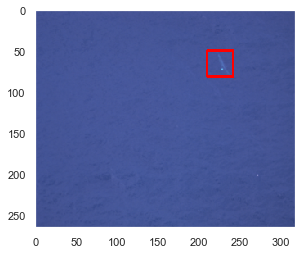

In [6]:
model.detect("dataset/Bioconsult/train/Whale/W42_F11-1048.png", sliding_size = 16)

Result file: object_detection_results/W52_F10-5505.png


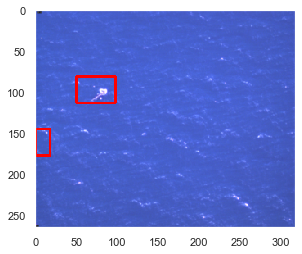

In [7]:
model.detect("dataset/Bioconsult/train/Whale/W52_F10-5505.png", sliding_size = 16)